# Using RNA read counts
### Using EUKelele to assign protistan taxonomy and generate relative community community based on RNA read counts

In [1]:
import pandas as pd

When working with an environmental transcriptomic data set, we often want to assign taxonomy using reference databases populated with cultured isolates. It can be useful to have a single assembly which all individual transcripts within samples can relate (map) back to in order to perform gene expression comparisons across samples. In this example we ran EUKulele with a single metatranscriptomic assembly that was created by combining 40 individual samples using the metatranscriptomic assembly pipeline "eukrhythmic" (https://github.com/AlexanderLabWHOI/eukrhythmic). We use the EUKulele output, combined with a separately compiled read counts table produced with salmon (https://salmon.readthedocs.io/en/latest/salmon.html), to visualize the breakdown of taxonomic groups within each sample.

EUKulele was performed using the MMETSP database and diamond as the alignment choice (default), as below:

`EUKulele -s /output/transdecoder_mega_merge --protein_extension .pep -m mets`

First, we load in the the annotated contig table located in the EUKulele output directory: 

`output/taxonomy_estimated/sample-estimated-taxonomy.out`

In [2]:
taxa=pd.read_table('merged_merged-estimated-taxonomy.out')
taxa.head()

,Unnamed: 0,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous
0,0,megahit_NarBay_A_megahit_NarBay_A_k111_0,species,Stramenopiles; Ochrophyta; Bacillariophyta; Ba...,Skeletonema grethea,100.0,0
1,0,megahit_NarBay_A_megahit_NarBay_A_k111_10,species,Hacrobia; Haptophyta; Prymnesiophyceae; Prymne...,Chrysochromulina ericina,95.5,0
2,0,megahit_NarBay_A_megahit_NarBay_A_k111_100,species,Hacrobia; Haptophyta; Prymnesiophyceae; Prymne...,Chrysochromulina ericina,100.0,0
3,0,megahit_NarBay_A_megahit_NarBay_A_k111_1005,species,Alveolata; Dinoflagellata; Dinophyceae; Proroc...,Prorocentrum minimum,100.0,0
4,0,megahit_NarBay_A_megahit_NarBay_A_k111_1008,family,Stramenopiles; Ochrophyta; Bacillariophyta; Ba...,Araphid-pennate,77.1,0


This file shows the result of the alignment, with each contig matching an annotation in the database listed alongside the level of classification achieved (classification_level & classification), full classification description as presented in the database (full_classification), the maximum percentage identity as calculated by the aligner (max_pid), and whether there were discrepancies assigning the taxonomic cutoff (ambiguous). Descriptions of the EUKulele output are provided here: https://eukulele.readthedocs.io/en/latest/

Next we want to separate out the classification levels in the "full_classification" column so that we can collapse counts based on the taxonomic level of interest. Be aware that the classification levels are specific to the taxonomic database used in the alignment, and the original references should be consulted to determine the appropriate levels:

In [5]:
df = pd.concat([taxa['transcript_name'], taxa['full_classification'].str.split('; ', expand=True)], axis=1)
#Label columns in data frame
df.columns = ['Name', 'Supergroup','Division','Class','Order','Family','Genus','Species']
df.head()

,Name,Supergroup,Division,Class,Order,Family,Genus,Species
0,megahit_NarBay_A_megahit_NarBay_A_k111_0,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Polar-centric-Mediophyceae,Skeletonema,Skeletonema grethea
1,megahit_NarBay_A_megahit_NarBay_A_k111_10,Hacrobia,Haptophyta,Prymnesiophyceae,Prymnesiales,Chrysochromulinaceae,Chrysochromulina,Chrysochromulina ericina
2,megahit_NarBay_A_megahit_NarBay_A_k111_100,Hacrobia,Haptophyta,Prymnesiophyceae,Prymnesiales,Chrysochromulinaceae,Chrysochromulina,Chrysochromulina ericina
3,megahit_NarBay_A_megahit_NarBay_A_k111_1005,Alveolata,Dinoflagellata,Dinophyceae,Prorocentrales,Prorocentraceae,Prorocentrum,Prorocentrum minimum
4,megahit_NarBay_A_megahit_NarBay_A_k111_1008,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Araphid-pennate,None,None


Next we create and read in a counts table created using standard salmon output, although a similar table could be generated using any read aligner. Counts from individual samples aligning to the fasta assembly are joined into one data frame. There are many ways to achieve this, and the approach below was adapted based on solutions posted on StackOverflow (https://stackoverflow.com/questions/44428429/replace-column-name-with-file-name-shell-script) and StackExchange (https://unix.stackexchange.com/questions/467523/awk-for-merging-multiple-files-with-common-column
). 

In [6]:
#Move over to the directory containing salmon output
%cd /vortexfs1/omics/alexander/ncohen/BATS2019-clio-metaT/EUKulele_NB/output/taxonomy_estimation/salmon_indiv_to_mega
! for i in *_quant/quant.sf; do awk -F, -v OFS=,  'NR==1{split(FILENAME,a,"_quant");$2= a[1] ""}1' ${i} | awk '{gsub(/\NumReads\,/,"",$5)}1'> ${i}_cleaned; done
! awk '{samples[$1] = samples[$1] OFS $NF}; END {print "Name", samples["Name"]; delete samples["Name"]; for (name in samples) print name, samples[name]}' */quant.sf_cleaned > table.tab
counts=pd.read_table('table.tab', sep = " ") 
%cd /vortexfs1/omics/alexander/ncohen/BATS2019-clio-metaT/EUKulele_NB/output/taxonomy_estimation
combined = df.join(counts.set_index('Name'), on='Name')
combined.head()

/vortexfs1/omics/alexander/ncohen/BATS2019-clio-metaT/EUKulele_NB/output/taxonomy_estimation/salmon_indiv_to_mega
/vortexfs1/omics/alexander/ncohen/BATS2019-clio-metaT/EUKulele_NB/output/taxonomy_estimation


,Name,Supergroup,Division,Class,Order,Family,Genus,Species,Unnamed: 1,SRR1810204,...,SRR1810207,SRR1810208,SRR1810209,SRR1810210,SRR1810211,SRR1810801,SRR181799,SRR1945044,SRR1945045,SRR1945046
0,megahit_NarBay_A_megahit_NarBay_A_k111_0,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Polar-centric-Mediophyceae,Skeletonema,Skeletonema grethea,NaN,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
1,megahit_NarBay_A_megahit_NarBay_A_k111_10,Hacrobia,Haptophyta,Prymnesiophyceae,Prymnesiales,Chrysochromulinaceae,Chrysochromulina,Chrysochromulina ericina,NaN,0.000,...,3.973,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
2,megahit_NarBay_A_megahit_NarBay_A_k111_100,Hacrobia,Haptophyta,Prymnesiophyceae,Prymnesiales,Chrysochromulinaceae,Chrysochromulina,Chrysochromulina ericina,NaN,9.369,...,7.093,4.902,15.165,0.0,5.869,8.824,0.0,0.0,0.0,0.0
3,megahit_NarBay_A_megahit_NarBay_A_k111_1005,Alveolata,Dinoflagellata,Dinophyceae,Prorocentrales,Prorocentraceae,Prorocentrum,Prorocentrum minimum,NaN,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0
4,megahit_NarBay_A_megahit_NarBay_A_k111_1008,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Araphid-pennate,None,None,NaN,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0


As a side note, it is also helpful during these environmental metatranscriptomic analyses to combine functional annotations alongside taxonomic identifications and read counts into one dataframe for downstream visualization, sharing, and exploration of the data. To do this, we can read in kegg annotations obtained by aligning our assembly against the KEGG database. [This is also performed within the eukrhythmic metatranscriptomic assembly pipeline using arKEGGio (https://github.com/AlexanderLabWHOI/eukrhythmic)]:

In [7]:
%cd /vortexfs1/omics/alexander/data/NB_subsampled_11Sept/kegg
kegg = pd.read_csv('cat.kegg.csv', sep ='\t')
%cd /vortexfs1/omics/alexander/ncohen/BATS2019-clio-metaT/EUKulele_NB/output/taxonomy_estimation
#Match columns containing contig IDs. In the counts dataframe, "Name" contains contig IDs. In the KEGG output, it is "query_id".
merged = kegg.join(combined.set_index('Name'), on='query_id') #Check this returns the correct counts/annotations 
merged.head()
#merged.to_csv('counts_taxa_kegg.csv') #Optional export of table to .csv file

/vortexfs1/omics/alexander/data/NB_subsampled_11Sept/kegg


/vortexfs1/home/ncohen/.conda/envs/EUKulele/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/vortexfs1/omics/alexander/ncohen/BATS2019-clio-metaT/EUKulele_NB/output/taxonomy_estimation


,KO,query_id,subject_id,perc_ident,length,mismatch,gapopen,qstart,qend,sstart,...,SRR1810207,SRR1810208,SRR1810209,SRR1810210,SRR1810211,SRR1810801,SRR181799,SRR1945044,SRR1945045,SRR1945046
0,K03283,megahit_NarBay_B_megahit_NarBay_B_k101_36771,smin:v1.2.008389.t1,92.1,151,12,0,49,501,6,...,2.479,1.431,10.28,0.0,3.311,0.0,0.0,0.0,0.0,0.0
1,K03283,megahit_NarBay_B_megahit_NarBay_B_k101_36771,smin:v1.2.025479.t1,92.1,139,11,0,85,501,2,...,2.479,1.431,10.28,0.0,3.311,0.0,0.0,0.0,0.0,0.0
2,K03283,megahit_NarBay_B_megahit_NarBay_B_k101_36771,tgo:TGME49_273760,83.4,151,25,0,49,501,6,...,2.479,1.431,10.28,0.0,3.311,0.0,0.0,0.0,0.0,0.0
3,K03283,megahit_NarBay_B_megahit_NarBay_B_k101_36771,ddi:DDB_G0273249,80.1,151,30,0,49,501,4,...,2.479,1.431,10.28,0.0,3.311,0.0,0.0,0.0,0.0,0.0
4,K03283,megahit_NarBay_B_megahit_NarBay_B_k101_36771,ddi:DDB_G0273623,80.1,151,30,0,49,501,4,...,2.479,1.431,10.28,0.0,3.311,0.0,0.0,0.0,0.0,0.0


Next we subset the counts/taxonomy dataframe to retain only the sample counts columns and the classification level of interest (in this case, Phylum):

In [8]:
#Subset out taxonomic level of interest and sample ID columns
subset = combined.loc[:, 'SRR1810204':'SRR1945046']
subset["Supergroup"]=combined["Supergroup"]
subset.head()

,SRR1810204,SRR1810205,SRR1810206,SRR1810207,SRR1810208,SRR1810209,SRR1810210,SRR1810211,SRR1810801,SRR181799,SRR1945044,SRR1945045,SRR1945046,Supergroup
0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,Stramenopiles
1,0.000,0.000,0.0,3.973,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,Hacrobia
2,9.369,1.001,0.0,7.093,4.902,15.165,0.0,5.869,8.824,0.0,0.0,0.0,0.0,Hacrobia
3,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,Alveolata
4,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,Stramenopiles


We import visualization libraries and a color palette

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.set_palette(sns.color_palette("husl", 10))

Next we collapse (sum) rows with the same taxonomic annotation. This table will be valuable for downstream applications such as reporting relative community abundance percentages:

In [10]:
#Group counts by Phylum in each sample
x = subset.groupby(['Supergroup']).sum()
#Save grouped dataframe to .csv file (optional)
#x.to_csv('counts_phylum.csv')

Lastly, we plot the results as a stacked barplot. This shows directly comparable community composition across samples using read counts. We conclude that we have a high relative abundance of Stramenopiles in these samples based on the transcript pool.

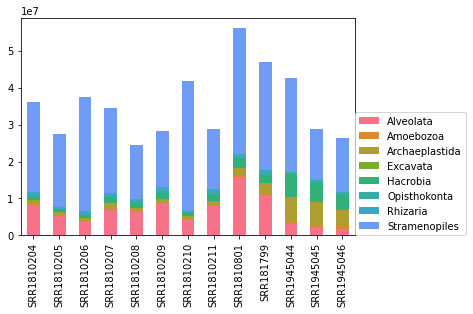

In [11]:
plot = x.T #Transpose dataframe
plot.head()
plot.plot.bar(stacked=True, legend=True).legend(loc=(1, 0))
color